<a href="https://colab.research.google.com/github/sizhky/Modern-Computer-Vision-with-PyTorch/blob/master/Chapter11/simple_auto_encoder_with_different_latent_size.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing vanilla autoencoders
In this Lab, we will implement an autoencoder using MNIST dataset, which contains images of handwritten digits.

In [ ]:
# Import the relevant packages and define the device
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import MNIST
from torchvision import transforms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Specify the transformation that we want our images to pass through
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [ ]:
# Create the train and validation datasets
trn_ds = MNIST('/content/', transform=img_transform, train=True, download=True)
val_ds = MNIST('/content/', transform=img_transform, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



In [ ]:
# Define the dataloaders
batch_size = 256
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the network architecture
class AutoEncoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latend_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128), nn.ReLU(True),
            nn.Linear(128, 64), nn.ReLU(True), 
            nn.Linear(64, latent_dim))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64), nn.ReLU(True),
            nn.Linear(64, 128), nn.ReLU(True), 
            nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        x = x.view(len(x), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(len(x), 1, 28, 28)
        return x

In [ ]:
# Visualize the model
!pip install torch_summary
from torchsummary import summary
model = AutoEncoder(3).to(device)
summary(model, torch.zeros(1,28,28));

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 3]                   --
|    └─Linear: 2-1                       [-1, 128]                 100,480
|    └─ReLU: 2-2                         [-1, 128]                 --
|    └─Linear: 2-3                       [-1, 64]                  8,256
|    └─ReLU: 2-4                         [-1, 64]                  --
|    └─Linear: 2-5                       [-1, 3]                   195
├─Sequential: 1-2                        [-1, 784]                 --
|    └─Linear: 2-6                       [-1, 64]                  256
|    └─ReLU: 2-7                         [-1, 64]                  --
|    └─Linear: 2-8                       [-1, 128]                 8,320
|    └─ReLU: 2-9                         [-1, 128]                 --
|    └─Linear: 2-10                      [-

In [ ]:
# Define a function to train on a batch of data 
def train_batch(input, model, criterion, optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = criterion(output, input)
    loss.backward()
    optimizer.step()
    return loss

# Define the function to validate on the batch of data 
@torch.no_grad()
def validate_batch(input, model, criterion):
    model.eval()
    output = model(input)
    loss = criterion(output, input)
    return loss

EPOCH: 1.000	trn_loss: 0.264	val_loss: 0.195	(16.59s - 66.35s remaining)
EPOCH: 2.000	trn_loss: 0.180	val_loss: 0.169	(31.17s - 46.75s remaining)
EPOCH: 3.000	trn_loss: 0.163	val_loss: 0.159	(45.94s - 30.63s remaining)
EPOCH: 4.000	trn_loss: 0.156	val_loss: 0.154	(60.28s - 15.07s remaining)
EPOCH: 5.000	trn_loss: 0.152	val_loss: 0.150	(75.38s - 0.00s remaining)


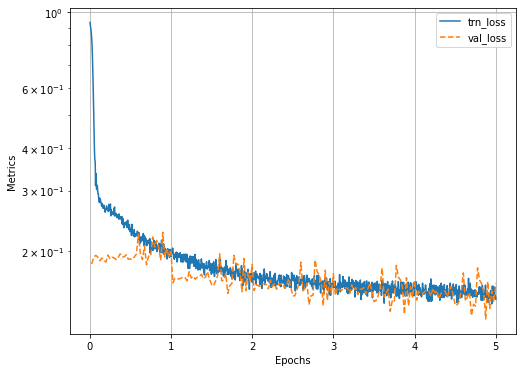

In [ ]:
# Define the model, loss criterion, and optimizer
model = AutoEncoder(3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 5
log = Report(num_epochs)

# Train the model over increasing epochs
for epoch in range(num_epochs):
    N = len(trn_dl)
    for ix, (data, _) in enumerate(trn_dl):
        loss = train_batch(data, model, criterion, optimizer)
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl):
        loss = validate_batch(data, model, criterion)
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs(epoch+1)

# Visualize the training and validation loss over increasing epochs    
log.plot(log=True)

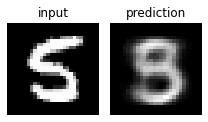

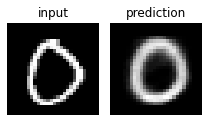

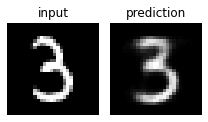

In [ ]:
# Validate the model on the val_ds dataset, which was not provided during training
for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    _im = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3)) 
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

We can see that the network can reproduce input with a very high level of accuracy even though the bottleneck layer is only three dimensions in size. However, the images are not as clear as we expect them to be. This is primarily because of the small number of nodes in the bottleneck layer. In the following image, we will visualize the reconstructed images after training networks with different bottleneck layer sizes: 2, 3, 5, 10, and 50:

EPOCH: 1.000	trn_loss: 0.233	val_loss: 0.137	(18.67s - 74.68s remaining)
EPOCH: 2.000	trn_loss: 0.117	val_loss: 0.100	(33.10s - 49.65s remaining)
EPOCH: 3.000	trn_loss: 0.093	val_loss: 0.083	(47.72s - 31.82s remaining)
EPOCH: 4.000	trn_loss: 0.079	val_loss: 0.073	(62.38s - 15.59s remaining)
EPOCH: 5.000	trn_loss: 0.072	val_loss: 0.067	(77.25s - 0.00s remaining)


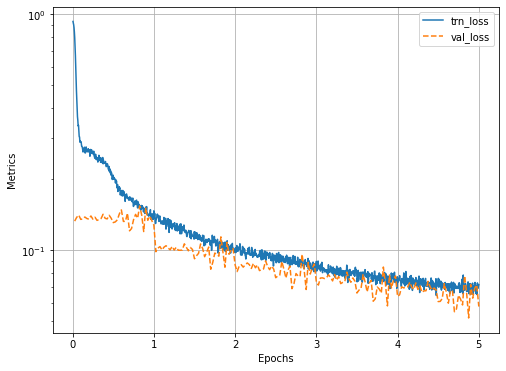

EPOCH: 1.000	trn_loss: 0.263	val_loss: 0.210	(14.96s - 59.83s remaining)
EPOCH: 2.000	trn_loss: 0.200	val_loss: 0.192	(30.14s - 45.21s remaining)
EPOCH: 3.000	trn_loss: 0.188	val_loss: 0.185	(44.69s - 29.80s remaining)
EPOCH: 4.000	trn_loss: 0.182	val_loss: 0.180	(59.32s - 14.83s remaining)
EPOCH: 5.000	trn_loss: 0.177	val_loss: 0.176	(73.94s - 0.00s remaining)


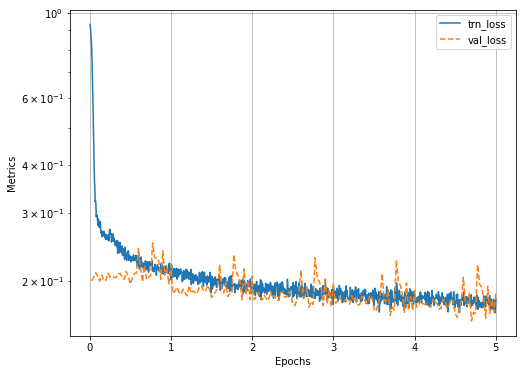

EPOCH: 1.000	trn_loss: 0.266	val_loss: 0.199	(14.58s - 58.32s remaining)
EPOCH: 2.000	trn_loss: 0.184	val_loss: 0.169	(29.19s - 43.79s remaining)
EPOCH: 3.000	trn_loss: 0.161	val_loss: 0.156	(43.66s - 29.11s remaining)
EPOCH: 4.000	trn_loss: 0.154	val_loss: 0.150	(58.05s - 14.51s remaining)
EPOCH: 5.000	trn_loss: 0.149	val_loss: 0.147	(72.30s - 0.00s remaining)


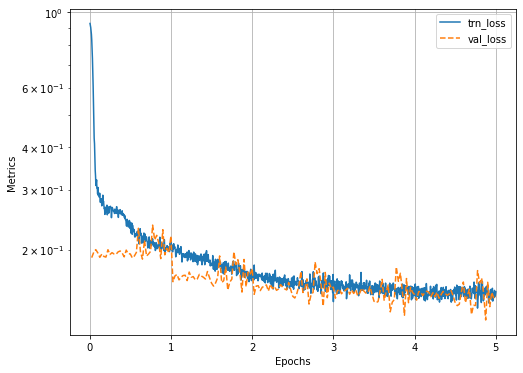

EPOCH: 1.000	trn_loss: 0.259	val_loss: 0.180	(14.98s - 59.92s remaining)
EPOCH: 2.000	trn_loss: 0.153	val_loss: 0.141	(29.35s - 44.03s remaining)
EPOCH: 3.000	trn_loss: 0.134	val_loss: 0.129	(43.65s - 29.10s remaining)
EPOCH: 4.000	trn_loss: 0.127	val_loss: 0.124	(57.88s - 14.47s remaining)
EPOCH: 5.000	trn_loss: 0.122	val_loss: 0.120	(72.35s - 0.00s remaining)


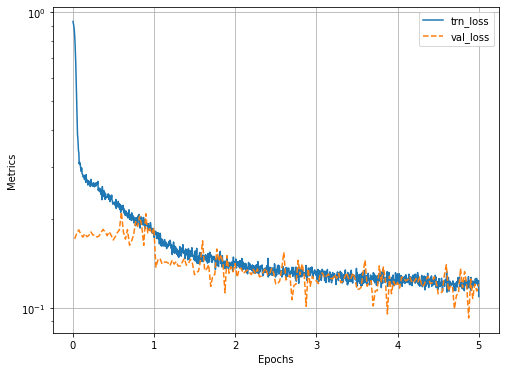

EPOCH: 1.000	trn_loss: 0.242	val_loss: 0.148	(14.46s - 57.83s remaining)
EPOCH: 2.000	trn_loss: 0.130	val_loss: 0.113	(28.92s - 43.38s remaining)
EPOCH: 3.000	trn_loss: 0.105	val_loss: 0.099	(43.23s - 28.82s remaining)
EPOCH: 4.000	trn_loss: 0.097	val_loss: 0.093	(57.24s - 14.31s remaining)
EPOCH: 5.000	trn_loss: 0.092	val_loss: 0.088	(72.01s - 0.00s remaining)


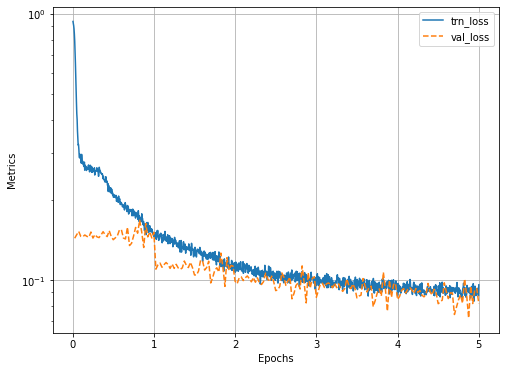

In [ ]:
def train_aec(latent_dim):
    model = AutoEncoder(latent_dim).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 5
    log = Report(num_epochs)

    for epoch in range(num_epochs):
        N = len(trn_dl)
        for ix, (data, _) in enumerate(trn_dl):
            loss = train_batch(data, model, criterion, optimizer)
            log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')

        N = len(val_dl)
        for ix, (data, _) in enumerate(val_dl):
            loss = validate_batch(data, model, criterion)
            log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        log.report_avgs(epoch+1)
    log.plot(log=True)
    return model

aecs = [train_aec(dim) for dim in [50, 2, 3, 5, 10]]

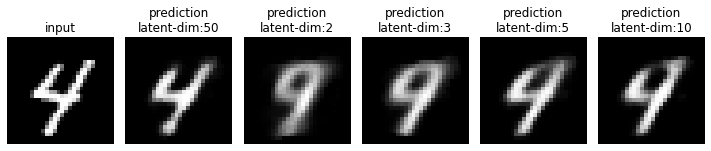

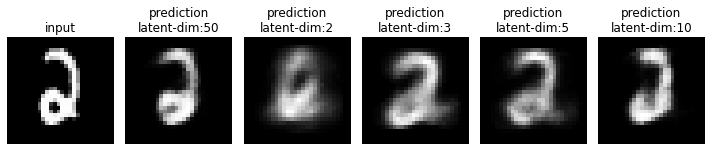

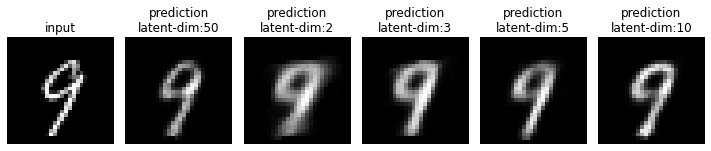

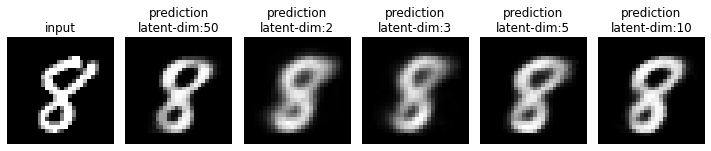

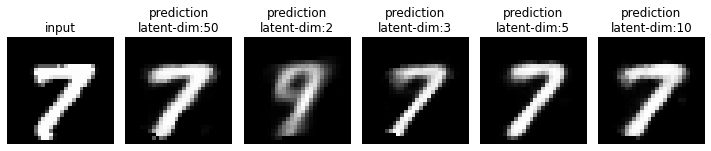

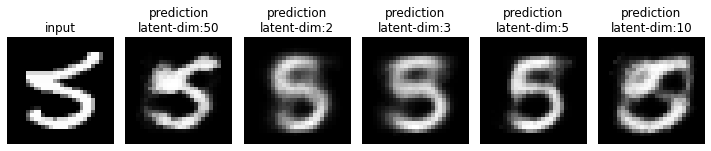

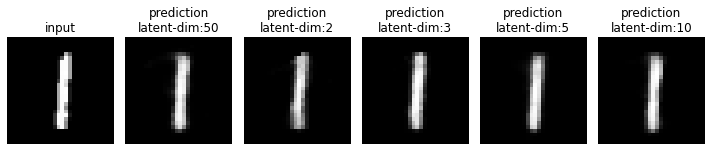

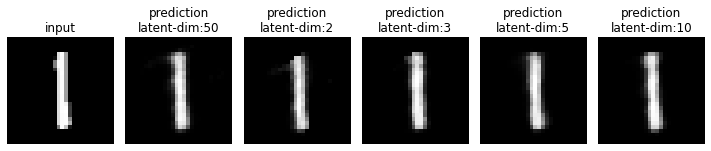

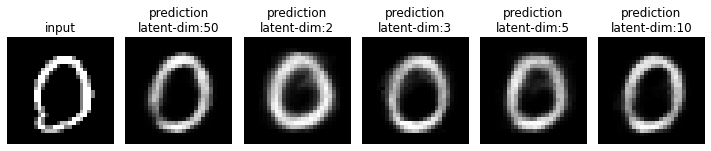

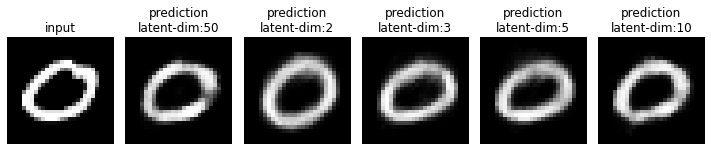

In [ ]:
for _ in range(10):
    ix = np.random.randint(len(val_ds))
    im, _ = val_ds[ix]
    fig, ax = plt.subplots(1, len(aecs)+1, figsize=(10,4))
    ax = iter(ax.flat)
    show(im[0], ax=next(ax), title='input')
    for model in aecs:
        _im = model(im[None])[0]
        show(_im[0], ax=next(ax), title=f'prediction\nlatent-dim:{model.latend_dim}')
    plt.tight_layout()
    plt.show()

It is clear that as the number of vectors in the bottleneck layer increased, the clarity of the reconstructed image improved.